In [7]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import os
import hvplot.pandas

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import folium
from folium.plugins import MarkerCluster
from folium import FeatureGroup

import numpy as np

import warnings
warnings.filterwarnings('ignore')

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

In [8]:
# define the Google Drive file URL
file_url = 'https://drive.google.com/uc?id=1N_hr60DCdSRyjmzerZlFeg8LGMmlbYUs'

# download the file from the Google Drive link
file_name = 'counties_gvd.csv'
gdown.download(file_url, file_name, quiet=False)

# Read the file into a dataframe
counties_gvd = pd.read_csv(file_name)

counties_gvd.head(10)

Downloading...
From: https://drive.google.com/uc?id=1N_hr60DCdSRyjmzerZlFeg8LGMmlbYUs
To: C:\Users\liats\git\project-4\Notebooks\counties_gvd.csv
100%|██████████| 1.73M/1.73M [00:03<00:00, 574kB/s]


,Unnamed: 0,county_Abbr,county_code,state,Area name,county,Abbr,deaths_per_100K_mean (1999-2020),deaths_per_100K_std (1999-2020),deaths_per_100K_numb_years (1999-2020),...,% indian pop avg (2010-2019),% pacific pop avg (2010-2019),% two pop avg (2010-2019),% not hisp pop avg (2010-2019),% hisp pop avg (2010-2019),chain restaurants per 100K,places of worship per 100K,name,lng,lat
0,0,"Autauga, AL - 1001",1001,Alabama,Autauga County,Autauga,AL,21.971571,3.796015,7.0,...,0.482159,0.092695,1.694992,97.354659,2.645341,105.211,110.653,Autauga,-86.642900,32.535142
1,1,"Baldwin, AL - 1003",1003,Alabama,Baldwin County,Baldwin,AL,13.911000,3.044843,22.0,...,0.675584,0.064112,1.549004,95.942130,4.057870,511.279,122.966,Baldwin,-87.722745,30.727825
2,2,"Barbour, AL - 1005",1005,Alabama,Barbour County,Barbour,AL,0.000000,0.000000,0.0,...,0.588415,0.114097,1.212456,96.934282,3.065718,228.194,121.083,Barbour,-85.391068,31.870090
3,3,"Bibb, AL - 1007",1007,Alabama,Bibb County,Bibb,AL,0.000000,0.000000,0.0,...,0.293741,0.116468,1.339917,96.980934,3.019066,19.214,50.859,Bibb,-87.126814,32.998376
4,4,"Blount, AL - 1009",1009,Alabama,Blount County,Blount,AL,20.789818,3.371535,11.0,...,0.478110,0.074876,1.467787,95.074459,4.925541,60.637,102.866,Blount,-86.567006,33.980871
5,5,"Bullock, AL - 1011",1011,Alabama,Bullock County,Bullock,AL,0.000000,0.000000,0.0,...,0.812255,0.727207,1.093199,92.387742,7.612258,66.892,496.909,Bullock,-85.715729,32.100459
6,6,"Butler, AL - 1013",1013,Alabama,Butler County,Butler,AL,53.438000,1.033790,2.0,...,0.338541,0.079006,1.809531,96.678093,3.321907,37.454,19.829,Butler,-86.680409,31.752524
7,7,"Calhoun, AL - 1015",1015,Alabama,Calhoun County,Calhoun,AL,22.073636,4.763029,22.0,...,0.624593,0.073066,2.175217,93.088344,6.911656,634.806,295.405,Calhoun,-85.825747,33.771415
8,8,"Chambers, AL - 1017",1017,Alabama,Chambers County,Chambers,AL,30.816500,2.779981,6.0,...,0.690550,0.075934,1.276193,87.630379,12.369621,142.806,156.538,Chambers,-85.391689,32.913666
9,9,"Cherokee, AL - 1019",1019,Alabama,Cherokee County,Cherokee,AL,43.946000,0.000000,1.0,...,4.395972,0.095229,2.712645,90.981619,9.018381,62.120,117.525,Cherokee,-85.603871,34.175887


In [9]:
counties_gvd.columns.to_list()

['Unnamed: 0',
 'county_Abbr',
 'county_code',
 'state',
 'Area name',
 'county',
 'Abbr',
 'deaths_per_100K_mean (1999-2020)',
 'deaths_per_100K_std (1999-2020)',
 'deaths_per_100K_numb_years (1999-2020)',
 'growth_rate_gun_laws (1991-2017)',
 'avg_pop (2010-2019)',
 'avg_murder (2002-2014)',
 'avg_rape (2002-2014)',
 'avg_robbery (2002-2014)',
 'avg_agasslt (2002-2014)',
 'avg_burglry (2002-2014)',
 'avg_larceny (2002-2014)',
 'avg_mvtheft (2002-2014)',
 'avg_arson (2002-2014)',
 'Poverty % overall (2014)',
 'Poverty % ages 0-17 (2014)',
 'Poverty % related kids age 5-17 (2014)',
 'Percent of adults with less than a high school diploma, 2010-2014',
 'Percent of adults with a high school diploma only, 2010-2014',
 "Percent of adults completing some college or associate's degree, 2010-2014",
 "Percent of adults with a bachelor's degree or higher, 2010-2014",
 'avg_unemp_rate_2010_2015',
 '% white pop avg (2010-2019)',
 '% black pop avg (2010-2019)',
 '% asian pop avg (2010-2019)',
 '% 

## Constructing a random forest model (binary, if deaths occur (1) or did not occur (0) for a given county

In [15]:
# description of the target column within the dataset
counties_gvd['deaths_per_100K_mean (1999-2020)'].describe()

count    3104.000000
mean        8.094753
std        12.506410
min         0.000000
25%         0.000000
50%         0.000000
75%        14.316057
max       120.074000
Name: deaths_per_100K_mean (1999-2020), dtype: float64

In [16]:
# create a copy of counties_gvd
copy_counties = counties_gvd.copy()

# Convert the target variable to binary, '0' for no deaths, all else, '1'
X = copy_counties
X['deaths_occurred_gt1'] = (X['deaths_per_100K_mean (1999-2020)'] != 0).astype(int)

# Define the target
y = X['deaths_occurred_gt1']

# Define features set
X.drop(['Unnamed: 0', 'county_Abbr', 'county_code', 'state', 'Area name', 'county', 
        'Abbr', 'deaths_per_100K_mean (1999-2020)', 'deaths_per_100K_std (1999-2020)', 
        'deaths_per_100K_numb_years (1999-2020)', 'deaths_occurred_gt1', 'name', 'lng', 'lat'], 
       axis=1, inplace=True)
""" for the app instead of the X.drop above, create a list of features - as checkboxes
and these will be entered into the model in real time. 
The app will display the number of features selected the accuracy and the confusion matrix  

['growth_rate_gun_laws (1991-2017)',
 'avg_pop (2010-2019)',
 'avg_murder (2002-2014)',
 'avg_rape (2002-2014)',
 'avg_robbery (2002-2014)',
 'avg_agasslt (2002-2014)',
 'avg_burglry (2002-2014)',
 'avg_larceny (2002-2014)',
 'avg_mvtheft (2002-2014)',
 'avg_arson (2002-2014)',
 'Poverty % overall (2014)',
 'Poverty % ages 0-17 (2014)',
 'Poverty % related kids age 5-17 (2014)',
 'Percent of adults with less than a high school diploma, 2010-2014',
 'Percent of adults with a high school diploma only, 2010-2014',
 "Percent of adults completing some college or associate's degree, 2010-2014",
 "Percent of adults with a bachelor's degree or higher, 2010-2014",
 'avg_unemp_rate_2010_2015',
 '% white pop avg (2010-2019)',
 '% black pop avg (2010-2019)',
 '% asian pop avg (2010-2019)',
 '% indian pop avg (2010-2019)',
 '% pacific pop avg (2010-2019)',
 '% two pop avg (2010-2019)',
 '% not hisp pop avg (2010-2019)',
 '% hisp pop avg (2010-2019)',
 'chain restaurants per 100K',
 'places of worship per 100K']
"""

# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

# Scaling the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

# Displaying results
print("Confusion Matrix")
print("~" * 30)
display(cm_df)
print("-" * 70)
print(f"Accuracy Score : {acc_score}")
print("-" * 70)
print()
print("Classification Report")
print("~" * 30)
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,417,32
Actual 1,41,286


Accuracy Score : 0.9059278350515464
Classification Report
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       449
           1       0.90      0.87      0.89       327

    accuracy                           0.91       776
   macro avg       0.90      0.90      0.90       776
weighted avg       0.91      0.91      0.91       776



## Feature importance of binary random forest model

In [17]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.16986019782296888, 'avg_mvtheft (2002-2014)'),
 (0.13741390102755877, 'avg_burglry (2002-2014)'),
 (0.11349459404624022, 'avg_larceny (2002-2014)'),
 (0.10136702718545913, 'avg_murder (2002-2014)'),
 (0.07565746540463254, 'avg_robbery (2002-2014)'),
 (0.06338227307371772, 'avg_agasslt (2002-2014)'),
 (0.049694888995596154, 'avg_arson (2002-2014)'),
 (0.047870977997898065, 'avg_rape (2002-2014)'),
 (0.03711714478323831, 'avg_pop (2010-2019)'),
 (0.015338985996918695, 'chain restaurants per 100K'),
 (0.013384339695527101, '% asian pop avg (2010-2019)'),
 (0.012957328628507583,
  'Percent of adults with a high school diploma only, 2010-2014'),
 (0.012925987501136568,
  "Percent of adults with a bachelor's degree or higher, 2010-2014"),
 (0.011492436074367077, 'Poverty % overall (2014)'),
 (0.011459254159225692, 'avg_unemp_rate_2010_2015'),
 (0.01114337898141135, 'places of worship per 100K'),
 (0.010580291007496018,
  "Percent of adults completing some college or associate's degree, 2

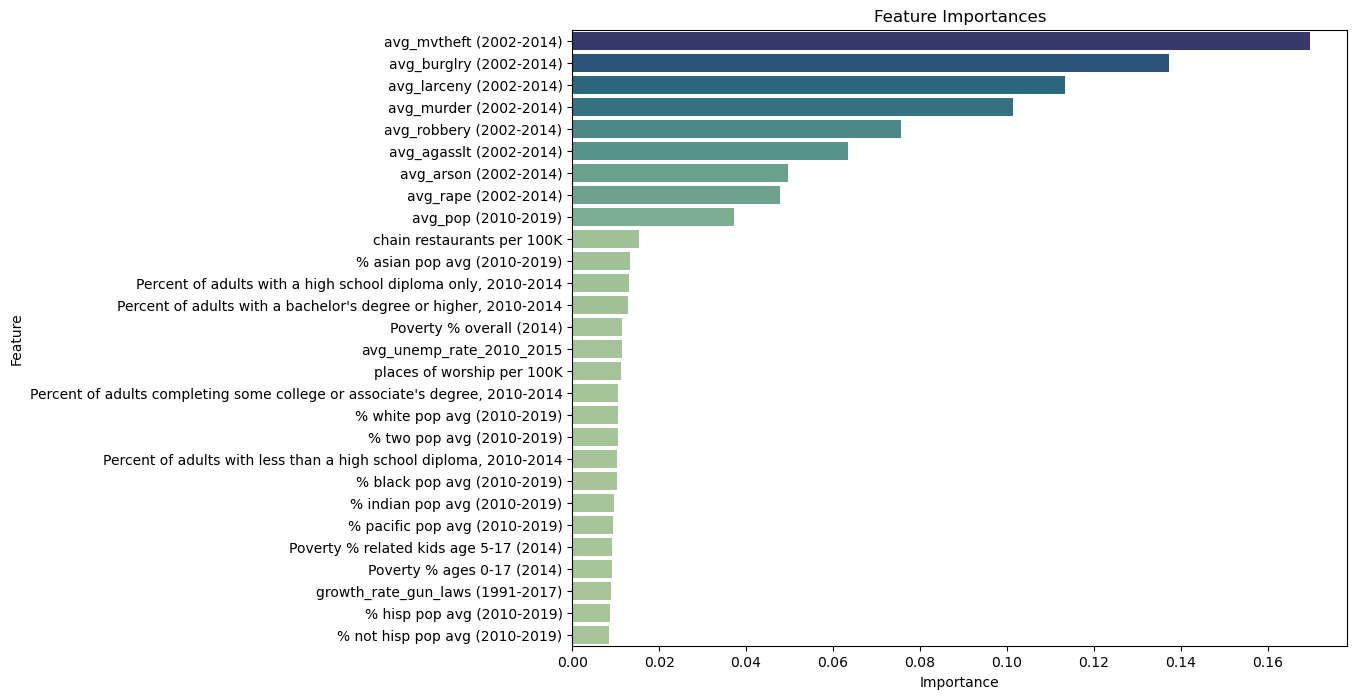

In [18]:
# Calculate feature importances
importances = rf_model.feature_importances_

# Convert feature importances into a pandas DataFrame
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True), columns=['Importance', 'Feature'])

# Normalize the importance scores to a 0-1 range
normalized = (importances_df['Importance'] - importances_df['Importance'].min()) / (importances_df['Importance'].max() - importances_df['Importance'].min())

# Plot the DataFrame using Seaborn
plt.figure(figsize=(10,8))
sns.barplot(y='Feature', x='Importance', data=importances_df, palette=sns.color_palette("crest", as_cmap=True)(normalized))
plt.title('Feature Importances')

# Save the figure
plt.savefig('../Output/figs/death_by_gun_occurs_gt1_rf.png', bbox_inches='tight')

# Show the plot
plt.show()


## Based on the binary model, calculate all probabilites for each county
## The probability a death by gun occurs in a county for a given year

In [19]:
# Add probabilities column to 'counties_gvd' and create new dataframe 'counties_gvd_prob'

# Copy dataframe and drop unnecessary columns
X_all = counties_gvd.copy()
X_all.drop(['county_Abbr', 'county_code', 'state', 'Area name', 'county', 'Abbr', 'deaths_per_100K_mean (1999-2020)', 'deaths_per_100K_std (1999-2020)', 'deaths_per_100K_numb_years (1999-2020)', 'name', 'lng', 'lat'], axis=1, inplace=True)

# Scale the data
X_all_scaled = X_scaler.transform(X_all)

# Use the model to predict the probability of death for all data
death_probabilities = rf_model.predict_proba(X_all_scaled)[:, 1]  # probabilities for the positive outcome is usually at index 1

# Create a new dataframe
counties_gvd_prob = counties_gvd.copy()

# Add the probabilities as a new column in your new DataFrame
counties_gvd_prob['death_probability'] = death_probabilities

# Create a CSV of 'counties_gvd_prob'
counties_gvd_prob.to_csv('../Output/counties_gvd_prob.csv', index=False)


# Display the first few rows of the DataFrame
display(counties_gvd_prob.sample(10))
print("Total number of rows in counties_gvd_prob:", counties_gvd_prob.shape[0])


,county_Abbr,county_code,state,Area name,county,Abbr,deaths_per_100K_mean (1999-2020),deaths_per_100K_std (1999-2020),deaths_per_100K_numb_years (1999-2020),growth_rate_gun_laws (1991-2017),avg_pop (2010-2019),avg_murder (2002-2014),avg_rape (2002-2014),avg_robbery (2002-2014),avg_agasslt (2002-2014),avg_burglry (2002-2014),avg_larceny (2002-2014),avg_mvtheft (2002-2014),avg_arson (2002-2014),Poverty % overall (2014),Poverty % ages 0-17 (2014),Poverty % related kids age 5-17 (2014),"Percent of adults with less than a high school diploma, 2010-2014","Percent of adults with a high school diploma only, 2010-2014","Percent of adults completing some college or associate's degree, 2010-2014","Percent of adults with a bachelor's degree or higher, 2010-2014",avg_unemp_rate_2010_2015,% white pop avg (2010-2019),% black pop avg (2010-2019),% asian pop avg (2010-2019),% indian pop avg (2010-2019),% pacific pop avg (2010-2019),% two pop avg (2010-2019),% not hisp pop avg (2010-2019),% hisp pop avg (2010-2019),chain restaurants per 100K,places of worship per 100K,name,lng,lat,death_probability
3083,"Campbell, WY - 56005",56005,Wyoming,Campbell County,Campbell,WY,24.194667,3.495218,3.0,1.098901,47205.02,0.538462,7.000000,3.230769,62.230769,162.384615,1032.076923,52.000000,10.307692,7.1,9.2,8.5,8.753734,35.921190,36.082301,19.242775,4.483333,92.280524,4.684756,0.827454,0.510963,0.053850,1.642452,96.854318,3.145682,154.645,67.789,Campbell,-105.548473,44.248066,0.842
1680,"Jefferson, NE - 31095",31095,Nebraska,Jefferson County,Jefferson,NE,0.000000,0.000000,0.0,0.854701,127942.76,0.230769,2.384615,0.076923,5.769231,27.538462,96.076923,7.230769,1.076923,11.5,16.7,15.0,10.496218,42.962553,33.370227,13.171002,3.700000,75.677295,19.615084,2.085339,0.698304,0.079520,1.844450,92.622263,7.377737,10.161,33.609,Jefferson,-97.142614,40.175808,0.002
1545,"Platte, MO - 29165",29165,Missouri,Platte County,Platte,MO,15.123714,3.190703,7.0,-2.403846,45970.03,6.076923,23.153846,114.000000,279.153846,533.153846,1744.846154,345.769231,28.076923,6.9,9.4,8.4,5.256499,23.221808,32.286945,39.234749,5.850000,89.809100,4.922555,2.127625,0.738742,0.368871,2.033129,91.443860,8.556161,485.099,308.897,Platte,-94.773801,39.380737,0.972
1228,"Clare, MI - 26035",26035,Michigan,Clare County,Clare,MI,32.513000,0.000000,1.0,-0.480769,30730.60,0.538462,22.769231,3.153846,52.461538,301.692308,474.230769,32.615385,7.538462,24.5,38.8,35.1,15.951003,40.200687,33.312240,10.536069,11.600000,96.788868,0.637475,0.290590,0.778703,0.027334,1.477029,98.156561,1.843439,191.991,146.434,Clare,-84.848108,43.987920,0.790
2260,"McKean, PA - 42083",42083,Pennsylvania,McKean County,McKean,PA,0.000000,0.000000,0.0,4.298643,42219.10,0.538462,12.615385,3.461538,72.923077,126.461538,488.615385,23.461538,6.461538,16.6,24.8,22.3,10.547185,48.899683,24.960349,15.592784,7.933333,95.566698,2.537951,0.558041,0.285416,0.004974,1.046920,97.990720,2.009280,175.276,139.747,McKean,-78.568880,41.807868,0.120
128,"Greene, AR - 5055",5055,Arkansas,Greene County,Greene,AR,26.350571,2.942256,7.0,-1.025641,55928.74,0.692308,17.923077,10.153846,84.769231,522.230769,1138.846154,100.769231,8.615385,16.3,23.0,21.7,16.156959,42.804857,26.130565,14.907619,7.966667,88.836241,6.794289,1.607581,0.548627,0.092207,2.121020,96.604375,3.395607,112.643,100.127,Greene,-90.558954,36.117733,0.930
2116,"Cherokee, OK - 40021",40021,Oklahoma,Cherokee County,Cherokee,OK,23.270500,2.480123,4.0,-0.384615,59561.80,1.692308,14.615385,8.769231,121.307692,323.769231,739.230769,82.307692,5.923077,20.6,28.6,27.7,14.572238,30.297310,31.210814,23.919639,6.666667,83.784154,7.807655,1.204329,4.395972,0.095229,2.712645,90.981619,9.018381,130.956,122.562,Cherokee,-94.999487,35.906643,0.960
303,"Tolland, CT - 9013",9013,Connecticut,Tolland County,Tolland,CT,7.439750,1.002751,4.0,8.831909,151649.40,0.615385,11.538462,15.692308,29.692308,170.230769,573.000000,52.538462,8.307692,7.5,7.3,6.3,6.805116,27.597484,28.841026,36.756374,6.533333,89.953801,3.59104

Total number of rows in counties_gvd_prob: 3104


In [20]:
counties_gvd_prob['death_probability'].describe()

count    3104.000000
mean        0.412106
std         0.436519
min         0.000000
25%         0.008000
50%         0.139000
75%         0.958500
max         1.000000
Name: death_probability, dtype: float64

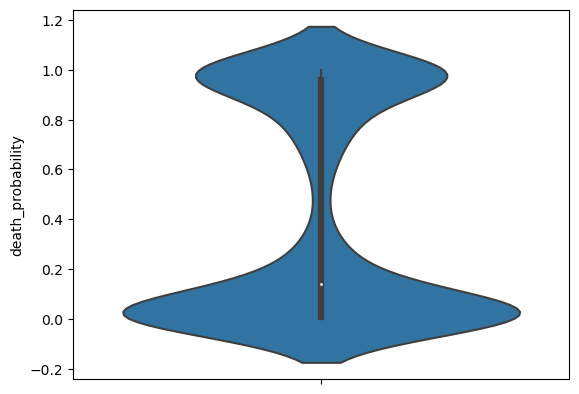

In [21]:
# construct a violin plot to see the distribution of values across the various probabilities

sns.violinplot(y='death_probability', data=counties_gvd_prob)
plt.show()

## Create a Folium Map

In [23]:
# Path to the GeoJSON file
file_id = '1LVRmvcdO3o_M_tHa1DiYbHWpXgUL_e_a'
filename = os.path.join('/Users/a/Desktop/GVD_Data', 'georef-united-states-of-america-county.geojson')
gdown.download(f'https://drive.google.com/uc?id={file_id}', filename, quiet=False)

geojson_path = filename

# Create a Map instance
m = folium.Map(location=[37.8, -96], zoom_start=4)

# Add GeoJSON layer
folium.GeoJson(
    geojson_path,
    name='US Counties',
    style_function=lambda feature: {
        'fillColor': '#ffff00',
        'color': 'black',
        'weight': 0.4,
        'dashArray': '5, 5'
    }
).add_to(m)

# Define different dataframes
prob1_df = counties_gvd_prob[counties_gvd_prob['death_probability'] <= 0.2]
prob2_df = counties_gvd_prob[(counties_gvd_prob['death_probability'] > 0.2) & (counties_gvd_prob['death_probability'] <= 0.8)]
prob3_df = counties_gvd_prob[counties_gvd_prob['death_probability'] > 0.8]

# Create MarkerClusters
prob1 = MarkerCluster(name='Death Probability: 0.0-0.2')
prob2 = MarkerCluster(name='Death Probability: 0.2-0.8')
prob3 = MarkerCluster(name='Death Probability: 0.8-1.0')

# Function to add markers
def add_marker(row, cluster):
    folium.Marker(
        [row['lat'], row['lng']], 
        tooltip=f"{row['county']}, {row['state']}<br>Probability of death by gun: <b>{row['death_probability']:.3f}</b>",
        popup=folium.Popup(f"Average Unemp. rate: <b>{round(row['avg_unemp_rate_2010_2015'], 2)}</b><br>"
                           f"Number of chain restaurants per 100,000 persons: <b>{round(row['chain restaurants per 100K'], 2)}</b><br>"
                           f"Number of places of worship per 100,000 persons: <b>{round(row['places of worship per 100K'], 2)}</b><br>"
                           f"Gun law growth rate from 1991-2017: <b>{round(row['growth_rate_gun_laws (1991-2017)'], 2)}</b>", max_width=300)
    ).add_to(cluster)

# Apply function to each row in the dataframes
prob1_df.apply(add_marker, axis=1, cluster=prob1)
prob2_df.apply(add_marker, axis=1, cluster=prob2)
prob3_df.apply(add_marker, axis=1, cluster=prob3)

# Create FeatureGroups for the different probabilities and add them to the map
group1 = folium.FeatureGroup(name="Probability: 0.0 - 0.2", show=False).add_child(prob1).add_to(m)
group2 = folium.FeatureGroup(name="Probability: 0.2 - 0.8", show=False).add_child(prob2).add_to(m)
group3 = folium.FeatureGroup(name="Probability: 0.8 - 1.0", show=False).add_child(prob3).add_to(m)

# Add layer control to the map
folium.LayerControl().add_to(m)

# Save it as html
m.save('/Users/a/Desktop/GVD_Data/Maps/binary_map_gt1_rf.html')


Downloading...
From: https://drive.google.com/uc?id=1LVRmvcdO3o_M_tHa1DiYbHWpXgUL_e_a
To: /Users/a/Desktop/GVD_Data/georef-united-states-of-america-county.geojson
100%|████████████████████████████████████████| 104M/104M [01:39<00:00, 1.05MB/s]


----------------------------------------------------------------------------------------------------

## Constructing a random forest model (binary, if deaths <= 14 return '0', deaths > 14 return '1' 

In [24]:
# create a copy of counties_gvd
copy_counties2 = counties_gvd.copy()

# Convert the target variable to binary, '0' for no deaths, all else, '1'
X = copy_counties2
# Convert the target variable to binary, '0' for no deaths, all else, '1'
X['deaths_occurred_gt14'] = (X['deaths_per_100K_mean (1999-2020)'] > 14).astype(int)

# Define the target
y = X['deaths_occurred_gt14']

# Define features set
X.drop(['county_Abbr', 'county_code', 'state', 'Area name', 'county', 'Abbr', 'deaths_per_100K_mean (1999-2020)', 'deaths_per_100K_std (1999-2020)', 'deaths_per_100K_numb_years (1999-2020)', 'deaths_occurred_gt14', 'name', 'lng', 'lat'], axis=1, inplace=True)

# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

# Scaling the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))





Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,525,41
Actual 1,73,137


Accuracy Score : 0.8530927835051546
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       566
           1       0.77      0.65      0.71       210

    accuracy                           0.85       776
   macro avg       0.82      0.79      0.80       776
weighted avg       0.85      0.85      0.85       776



## Feature importance of binary random forest model for 8 or more gun deaths per county

In [25]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.10025211390308679, 'avg_mvtheft (2002-2014)'),
 (0.07906425582410234, 'avg_larceny (2002-2014)'),
 (0.07069858098275413, 'avg_burglry (2002-2014)'),
 (0.058553539949591255, 'avg_murder (2002-2014)'),
 (0.05007806556680152, 'avg_pop (2010-2019)'),
 (0.04506861102325745, 'avg_robbery (2002-2014)'),
 (0.043447427198796, 'avg_rape (2002-2014)'),
 (0.03899906352233671, 'avg_agasslt (2002-2014)'),
 (0.03762064221132494, 'Poverty % ages 0-17 (2014)'),
 (0.03687576293244644, 'avg_arson (2002-2014)'),
 (0.035201854978221106, 'Poverty % related kids age 5-17 (2014)'),
 (0.03314144236526482, 'Poverty % overall (2014)'),
 (0.030726743484703032,
  "Percent of adults with a bachelor's degree or higher, 2010-2014"),
 (0.02910683187540216,
  'Percent of adults with less than a high school diploma, 2010-2014'),
 (0.028734775393923512, 'growth_rate_gun_laws (1991-2017)'),
 (0.027722906588587674, '% asian pop avg (2010-2019)'),
 (0.024766735362705915, '% black pop avg (2010-2019)'),
 (0.0236457040128

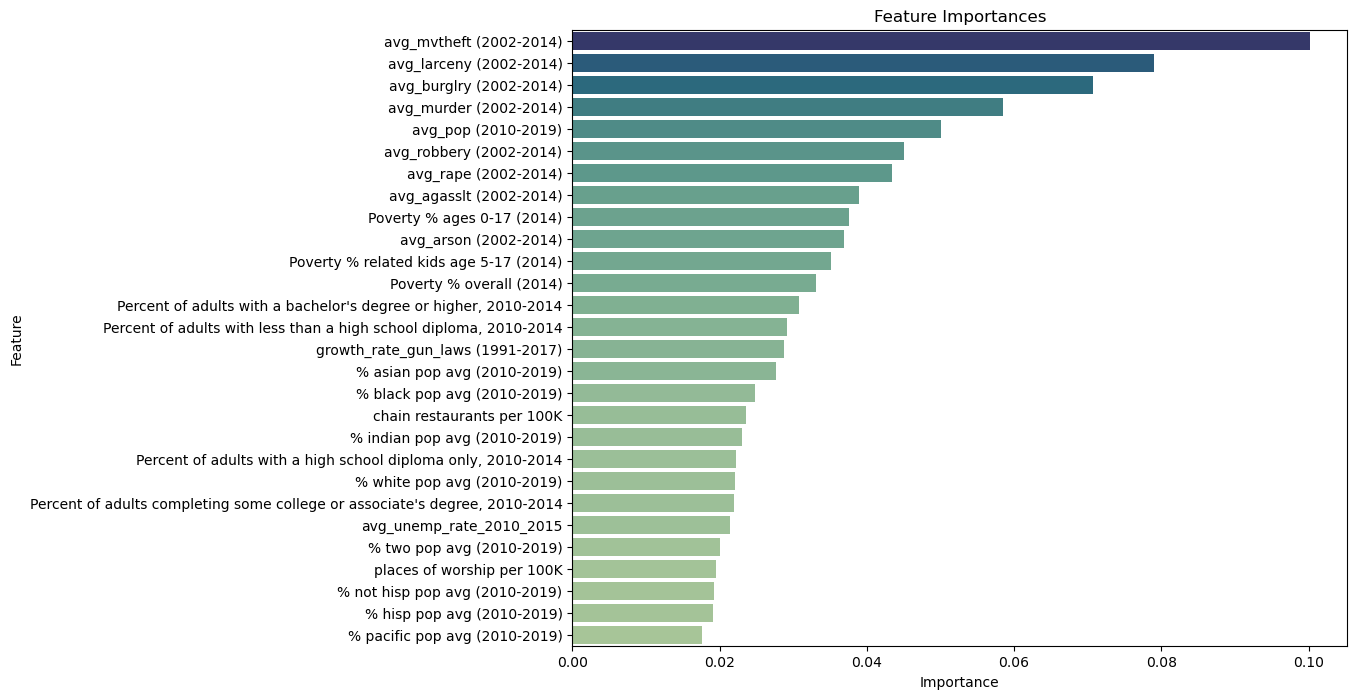

In [26]:
# Calculate feature importances
importances = rf_model.feature_importances_

# Convert feature importances into a pandas DataFrame
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True), columns=['Importance', 'Feature'])

# Normalize the importance scores to a 0-1 range
normalized = (importances_df['Importance'] - importances_df['Importance'].min()) / (importances_df['Importance'].max() - importances_df['Importance'].min())

# Plot the DataFrame using Seaborn
plt.figure(figsize=(10,8))
sns.barplot(y='Feature', x='Importance', data=importances_df, palette=sns.color_palette("crest", as_cmap=True)(normalized))
plt.title('Feature Importances')

# Save the figure
plt.savefig('../Output/figs/death_by_gun_gt14.png', bbox_inches='tight')

# Show the plot
plt.show()


## Based on the binary model, calculate all probabilites for each county
## The probability that at least 14 deaths by gun occur in a county per year

In [27]:
# Add probabilities column to 'counties_gvd' and create new dataframe 'counties_gvd_prob'

# Copy dataframe and drop unnecessary columns
X_all = counties_gvd.copy()
X_all.drop(['county_Abbr', 'county_code', 'state', 'Area name', 'county', 'Abbr', 'deaths_per_100K_mean (1999-2020)', 'deaths_per_100K_std (1999-2020)', 'deaths_per_100K_numb_years (1999-2020)', 'name', 'lng', 'lat'], axis=1, inplace=True)

# Scale the data
X_all_scaled = X_scaler.transform(X_all)

# Use the model to predict the probability of death for all data
death_probabilities = rf_model.predict_proba(X_all_scaled)[:, 1]  # probabilities for the positive outcome is usually at index 1

# Create a new dataframe
counties_gvd_prob_gt14 = counties_gvd.copy()

# Add the probabilities as a new column in your new DataFrame
counties_gvd_prob_gt14['death_probability'] = death_probabilities

# Create a CSV of 'counties_gvd_prob'
counties_gvd_prob_gt14.to_csv('../Output/counties_gvd_prob_gt14.csv', index=False)


# Display the first few rows of the DataFrame
display(counties_gvd_prob_gt14.sample(10))
print("Total number of rows in counties_gvd_prob_gt14:", counties_gvd_prob_gt14.shape[0])


,county_Abbr,county_code,state,Area name,county,Abbr,deaths_per_100K_mean (1999-2020),deaths_per_100K_std (1999-2020),deaths_per_100K_numb_years (1999-2020),growth_rate_gun_laws (1991-2017),avg_pop (2010-2019),avg_murder (2002-2014),avg_rape (2002-2014),avg_robbery (2002-2014),avg_agasslt (2002-2014),avg_burglry (2002-2014),avg_larceny (2002-2014),avg_mvtheft (2002-2014),avg_arson (2002-2014),Poverty % overall (2014),Poverty % ages 0-17 (2014),Poverty % related kids age 5-17 (2014),"Percent of adults with less than a high school diploma, 2010-2014","Percent of adults with a high school diploma only, 2010-2014","Percent of adults completing some college or associate's degree, 2010-2014","Percent of adults with a bachelor's degree or higher, 2010-2014",avg_unemp_rate_2010_2015,% white pop avg (2010-2019),% black pop avg (2010-2019),% asian pop avg (2010-2019),% indian pop avg (2010-2019),% pacific pop avg (2010-2019),% two pop avg (2010-2019),% not hisp pop avg (2010-2019),% hisp pop avg (2010-2019),chain restaurants per 100K,places of worship per 100K,name,lng,lat,death_probability
422,"Early, GA - 13099",13099,Georgia,Early County,Early,GA,0.000000,0.000000,0.0,-1.923077,10498.90,0.769231,4.000000,7.461538,49.384615,91.000000,174.846154,10.692308,0.000000,29.9,40.6,37.8,20.178673,38.754963,26.219512,14.846852,9.666667,47.830725,50.279553,0.566726,0.480050,0.029527,0.813419,97.952166,2.047834,161.922,257.170,Early,-84.904240,31.323174,0.030
463,"Long, GA - 13183",13183,Georgia,Long County,Long,GA,0.000000,0.000000,0.0,-1.923077,17251.90,0.384615,4.076923,5.000000,18.769231,106.076923,128.076923,18.769231,1.153846,21.9,31.3,29.9,15.687320,38.402474,32.046497,13.863709,7.850000,67.458657,26.197115,1.206244,0.809186,0.434735,3.894064,88.458663,11.541337,46.372,295.620,Long,-81.745446,31.752465,0.046
1073,"Robertson, KY - 21201",21201,Kentucky,Robertson County,Robertson,KY,0.000000,0.000000,0.0,-0.480769,29203.23,0.000000,0.000000,0.000000,0.000000,0.461538,0.692308,0.000000,0.000000,23.0,35.0,29.1,28.756477,34.132124,22.215026,14.896373,9.766667,87.196622,10.001873,0.643525,0.612158,0.083313,1.462509,91.087869,8.912131,10.273,58.213,Robertson,-84.051880,38.517784,0.000
1775,"Colfax, NM - 35007",35007,New Mexico,Colfax County,Colfax,NM,0.000000,0.000000,0.0,0.000000,11677.45,0.384615,2.615385,2.692308,38.538462,108.076923,124.692308,12.153846,1.769231,20.5,30.6,27.2,13.070475,33.302287,33.053917,20.573321,7.300000,92.325379,2.217522,0.753589,2.814827,0.335690,1.552993,53.366531,46.633469,462.430,239.778,Colfax,-104.646873,36.606199,0.032
500,"Stewart, GA - 13259",13259,Georgia,Stewart County,Stewart,GA,0.000000,0.000000,0.0,-1.923077,9731.05,0.230769,0.461538,3.384615,17.384615,27.846154,34.461538,3.846154,0.230769,39.4,44.7,43.9,38.081937,38.035382,14.222533,9.660149,8.700000,78.991990,17.161560,1.348775,0.692628,0.029802,1.775245,89.485718,10.514282,30.829,164.422,Stewart,-84.833953,32.078396,0.000
2616,"Jefferson, TX - 48245",48245,Texas,Jefferson County,Jefferson,TX,14.725318,3.198682,22.0,1.479290,127942.76,19.538462,128.461538,528.923077,973.076923,3213.615385,7812.230769,742.846154,87.000000,21.2,32.3,30.1,17.148088,33.353008,31.513648,17.985256,9.966667,75.677295,19.615084,2.085339,0.698304,0.079520,1.844450,92.622263,7.377737,361.881,225.101,Jefferson,-94.163071,29.883376,0.944
2723,"Walker, TX - 48471",48471,Texas,Walker County,Walker,TX,18.141000,2.349009,2.0,1.479290,68193.20,1.923077,27.692308,36.615385,177.846154,407.923077,1073.923077,86.769231,3.615385,26.3,27.9,26.4,17.130409,34.851445,29.587460,18.430686,6.600000,85.739194,11.401533,0.738534,0.545318,0.083777,1.491644,92.539432,7.460568,181.836,109.982,Walker,-95.572479,30.738835,0.988
1302,"Carlton, MN - 27017",27017,Minnesota,Carlton County,Carlton,MN,0.000000,0.000000,0.0,6.666667,35490.90,0.461538,10.384615,3.384615,30.384615,133.538462,658.153846,43.000000,3.692308,12.1,13.7,12.0,6.840577,36.496709,34.354173,22.308542,6.483333,89.444618,1.581250,0.503228,5.99

Total number of rows in counties_gvd_prob_gt14: 3104


In [28]:
counties_gvd_prob_gt14['death_probability'].describe()

count    3104.000000
mean        0.255373
std         0.337969
min         0.000000
25%         0.006000
50%         0.070000
75%         0.468500
max         0.998000
Name: death_probability, dtype: float64

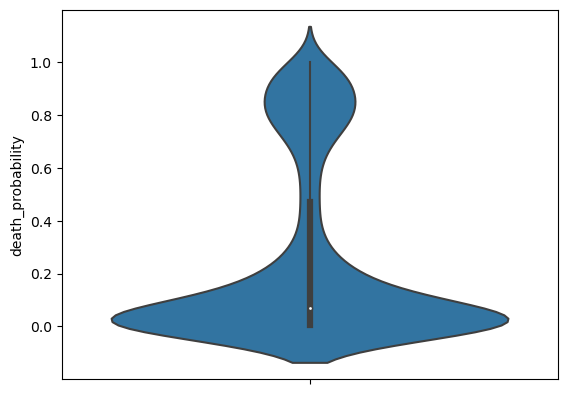

In [29]:
# construct a violin plot to see the distribution of values across the various probabilities

sns.violinplot(y='death_probability', data=counties_gvd_prob_gt14)
plt.show()

## Create a Folium Map

In [30]:
# Path to the GeoJSON file
file_id = '1LVRmvcdO3o_M_tHa1DiYbHWpXgUL_e_a'
filename = os.path.join('/Users/a/Desktop/GVD_Data', 'georef-united-states-of-america-county.geojson')
gdown.download(f'https://drive.google.com/uc?id={file_id}', filename, quiet=False)

geojson_path = filename

# Create a Map instance
m = folium.Map(location=[37.8, -96], zoom_start=4)

# Add GeoJSON layer
folium.GeoJson(
    geojson_path,
    name='US Counties',
    style_function=lambda feature: {
        'fillColor': '#ffff00',
        'color': 'black',
        'weight': 0.4,
        'dashArray': '5, 5'
    }
).add_to(m)

# Define different dataframes
prob1_df = counties_gvd_prob_gt14[counties_gvd_prob_gt14['death_probability'] <= 0.8]
prob2_df = counties_gvd_prob_gt14[counties_gvd_prob_gt14['death_probability'] > 0.8]

# Create MarkerClusters
prob1 = MarkerCluster(name='Death Probability: 0.0-0.8')
prob2 = MarkerCluster(name='Death Probability: 0.8-1.0')

# Function to add markers
def add_marker(row, cluster):
    folium.Marker(
        [row['lat'], row['lng']], 
        tooltip=f"{row['county']}, {row['state']}<br>Probability of death by gun: <b>{row['death_probability']:.3f}</b>",
        popup=folium.Popup(f"Average Unemp. rate: <b>{round(row['avg_unemp_rate_2010_2015'], 2)}</b><br>"
                           f"Number of chain restaurants per 100,000 persons: <b>{round(row['chain restaurants per 100K'], 2)}</b><br>"
                           f"Number of places of worship per 100,000 persons: <b>{round(row['places of worship per 100K'], 2)}</b><br>"
                           f"Gun law growth rate from 1991-2017: <b>{round(row['growth_rate_gun_laws (1991-2017)'], 2)}</b>", max_width=300)
    ).add_to(cluster)

# Apply function to each row in the dataframes
prob1_df.apply(add_marker, axis=1, cluster=prob1)
prob2_df.apply(add_marker, axis=1, cluster=prob2)

# Create FeatureGroups for the different probabilities and add them to the map
group1 = folium.FeatureGroup(name="Probability: 0.0 - 0.8", show=False).add_child(prob1).add_to(m)
group2 = folium.FeatureGroup(name="Probability: 0.8 - 1.0", show=False).add_child(prob2).add_to(m)

# Add layer control to the map
folium.LayerControl().add_to(m)

# Save it as html
m.save('/Users/a/Desktop/GVD_Data/Maps/binary_map_gt14_rf.html')


Downloading...
From: https://drive.google.com/uc?id=1LVRmvcdO3o_M_tHa1DiYbHWpXgUL_e_a
To: /Users/a/Desktop/GVD_Data/georef-united-states-of-america-county.geojson
100%|████████████████████████████████████████| 104M/104M [01:14<00:00, 1.40MB/s]


----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

## Tune & create a neural network model (binary, if deaths occur (1) or did not occur (0) for a given county

In [31]:
# create a copy of counties_gvd
copy_counties = counties_gvd.copy()

# Convert the target variable to binary, '0' for no deaths, all else, '1'
X = copy_counties
X['deaths_occurred_gt1'] = (X['deaths_per_100K_mean (1999-2020)'] != 0).astype(int)

# Define the target
y = X['deaths_occurred_gt1']

# Define features set
X.drop(['county_Abbr', 'county_code', 'state', 'Area name', 'county', 'Abbr', 'deaths_per_100K_mean (1999-2020)', 'deaths_per_100K_std (1999-2020)', 'deaths_per_100K_numb_years (1999-2020)', 'deaths_occurred_gt1', 'name', 'lng', 'lat'], axis=1, inplace=True)

# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

# Scaling the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid','swish'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=10,
        step=2), activation=activation, input_dim=X_train_scaled.shape[1])) # This code 'input_dim=X_train_scaled.shape[1]' indicates the shape of the dataset

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=10,
            step=2),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

import datetime # this ensures that a new folder will be made for every run of this code
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


# Create a `Hyperband()` tuner instance
directory_path = '/Users/a/Desktop/GVD_Data/hyberband_results'
tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=40,
    hyperband_iterations=2,
    directory=f'{directory_path}/hyperband_{current_time}',
    project_name='keras_tuner')

# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=40,validation_data=(X_test_scaled,y_test))

# View the results
tuner.results_summary()


Trial 180 Complete [00h 00m 32s]
val_accuracy: 0.8956185579299927

Best val_accuracy So Far: 0.9033505320549011
Total elapsed time: 00h 23m 50s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in /Users/a/Desktop/GVD_Data/hyberband_results/hyperband_20230531-162729/keras_tuner
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0082 summary
Hyperparameters:
activation: swish
first_units: 3
num_layers: 4
units_0: 9
units_1: 1
units_2: 1
units_3: 7
units_4: 9
units_5: 5
tuner/epochs: 40
tuner/initial_epoch: 14
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0080
Score: 0.9033505320549011

Trial 0051 summary
Hyperparameters:
activation: swish
first_units: 9
num_layers: 3
units_0: 7
units_1: 1
units_2: 7
units_3: 7
units_4: 9
units_5: 3
tuner/epochs: 40
tuner/initial_epoch: 14
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0048
Score: 0.9020618796348572

Trial 0174 summary
Hyperparameters:
activation: swish
first_units: 9
num_layers: 4
units_0: 5
uni

In [32]:
# Create a Keras Sequential model
nn_model = tf.keras.models.Sequential()

# First layer with input dimension and "swish" activation function
nn_model.add(tf.keras.layers.Dense(units=3, activation="swish", input_dim=X_train_scaled.shape[1]))

# Add more layers according to the best hyperparameters found
nn_model.add(tf.keras.layers.Dense(units=9, activation="swish"))
nn_model.add(tf.keras.layers.Dense(units=1, activation="swish"))
nn_model.add(tf.keras.layers.Dense(units=1, activation="swish"))
nn_model.add(tf.keras.layers.Dense(units=7, activation="swish"))

# Output layer
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the Sequential model
nn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 3)                 87        
                                                                 
 dense_8 (Dense)             (None, 9)                 36        
                                                                 
 dense_9 (Dense)             (None, 1)                 10        
                                                                 
 dense_10 (Dense)            (None, 1)                 2         
                                                                 
 dense_11 (Dense)            (None, 7)                 14        
                                                                 
 dense_12 (Dense)            (None, 1)                 8         
                                                                 
Total params: 157
Trainable params: 157
Non-trainable 

In [33]:
# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compile the model
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fit the model, and include the early stopping callback in the fit() method's callbacks parameter
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=200, validation_data=(X_test_scaled, y_test), callbacks=[early_stopping])


Epoch 1/200
73/73 [==============================] - 4s 40ms/step - loss: 0.6852 - accuracy: 0.5846 - val_loss: 0.6778 - val_accuracy: 0.5941
Epoch 2/200
73/73 [==============================] - 1s 13ms/step - loss: 0.6727 - accuracy: 0.6057 - val_loss: 0.6648 - val_accuracy: 0.6031
Epoch 3/200
73/73 [==============================] - 1s 10ms/step - loss: 0.6468 - accuracy: 0.6353 - val_loss: 0.6319 - val_accuracy: 0.6534
Epoch 4/200
73/73 [==============================] - 1s 9ms/step - loss: 0.5846 - accuracy: 0.7259 - val_loss: 0.5733 - val_accuracy: 0.7320
Epoch 5/200
73/73 [==============================] - 1s 8ms/step - loss: 0.5207 - accuracy: 0.7719 - val_loss: 0.5263 - val_accuracy: 0.7719
Epoch 6/200
73/73 [==============================] - 1s 9ms/step - loss: 0.4715 - accuracy: 0.8050 - val_loss: 0.4884 - val_accuracy: 0.7809
Epoch 7/200
73/73 [==============================] - 1s 9ms/step - loss: 0.4290 - accuracy: 0.8213 - val_loss: 0.4558 - val_accuracy: 0.8093
Epoch 8/20

Epoch 59/200
73/73 [==============================] - 1s 7ms/step - loss: 0.2287 - accuracy: 0.8973 - val_loss: 0.2560 - val_accuracy: 0.8995
Epoch 60/200
73/73 [==============================] - 1s 7ms/step - loss: 0.2271 - accuracy: 0.8991 - val_loss: 0.2602 - val_accuracy: 0.9046
Epoch 61/200
73/73 [==============================] - 1s 7ms/step - loss: 0.2268 - accuracy: 0.8969 - val_loss: 0.2561 - val_accuracy: 0.9034
Epoch 62/200
73/73 [==============================] - 1s 7ms/step - loss: 0.2263 - accuracy: 0.8991 - val_loss: 0.2528 - val_accuracy: 0.8982
Epoch 63/200
73/73 [==============================] - 1s 7ms/step - loss: 0.2267 - accuracy: 0.8982 - val_loss: 0.2545 - val_accuracy: 0.9034
Epoch 64/200
73/73 [==============================] - 1s 7ms/step - loss: 0.2260 - accuracy: 0.9038 - val_loss: 0.2566 - val_accuracy: 0.8995
Epoch 65/200
73/73 [==============================] - 1s 8ms/step - loss: 0.2266 - accuracy: 0.8978 - val_loss: 0.2529 - val_accuracy: 0.8982
Epoch 

In [36]:
# Making predictions using the testing data
predictions_proba = nn_model.predict(X_test_scaled)
predictions = np.round(predictions_proba).astype(int) # rounding off the probabilities and converting to integers

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

25/25 [==============================] - 0s 2ms/step
Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,426,23
Actual 1,45,282


Accuracy Score : 0.9123711340206185
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       449
           1       0.92      0.86      0.89       327

    accuracy                           0.91       776
   macro avg       0.91      0.91      0.91       776
weighted avg       0.91      0.91      0.91       776



In [37]:
# Copy dataframe and drop unnecessary columns
X_all = counties_gvd.copy()
X_all.drop(['county_Abbr', 'county_code', 'state', 'Area name', 'county', 'Abbr', 'deaths_per_100K_mean (1999-2020)', 'deaths_per_100K_std (1999-2020)', 'deaths_per_100K_numb_years (1999-2020)', 'name', 'lng', 'lat'], axis=1, inplace=True)

# Scale all data
X_all_scaled = X_scaler.transform(X_all)

# Use the model to predict the probability of death for all data
death_probabilities = nn_model.predict(X_all_scaled)[:, 0]  # probabilities for the positive outcome is at index 0 for a neural network with sigmoid output

# Create a new dataframe
counties_gvd_prob_nn = counties_gvd.copy()

# Add the probabilities as a new column in your new DataFrame
counties_gvd_prob_nn['death_probability'] = death_probabilities

# Create a CSV of 'counties_gvd_prob'
counties_gvd_prob_nn.to_csv('../Output/counties_gvd_prob_nn.csv', index=False)

# Display the first few rows of the DataFrame
display(counties_gvd_prob_nn.sample(10))
print("Total number of rows in counties_gvd_prob_nn:", counties_gvd_prob_nn.shape[0])


97/97 [==============================] - 0s 2ms/step


,county_Abbr,county_code,state,Area name,county,Abbr,deaths_per_100K_mean (1999-2020),deaths_per_100K_std (1999-2020),deaths_per_100K_numb_years (1999-2020),growth_rate_gun_laws (1991-2017),avg_pop (2010-2019),avg_murder (2002-2014),avg_rape (2002-2014),avg_robbery (2002-2014),avg_agasslt (2002-2014),avg_burglry (2002-2014),avg_larceny (2002-2014),avg_mvtheft (2002-2014),avg_arson (2002-2014),Poverty % overall (2014),Poverty % ages 0-17 (2014),Poverty % related kids age 5-17 (2014),"Percent of adults with less than a high school diploma, 2010-2014","Percent of adults with a high school diploma only, 2010-2014","Percent of adults completing some college or associate's degree, 2010-2014","Percent of adults with a bachelor's degree or higher, 2010-2014",avg_unemp_rate_2010_2015,% white pop avg (2010-2019),% black pop avg (2010-2019),% asian pop avg (2010-2019),% indian pop avg (2010-2019),% pacific pop avg (2010-2019),% two pop avg (2010-2019),% not hisp pop avg (2010-2019),% hisp pop avg (2010-2019),chain restaurants per 100K,places of worship per 100K,name,lng,lat,death_probability
1448,"Tallahatchie, MS - 28135",28135,Mississippi,Tallahatchie County,Tallahatchie,MS,0.0,0.0,0.0,-1.442308,14611.80,0.230769,0.615385,9.923077,9.615385,21.384615,35.769231,0.692308,0.230769,37.4,47.7,47.1,33.365348,33.154053,23.770649,9.709950,10.533333,40.766367,56.817093,0.923911,0.375039,0.095813,1.021777,93.686609,6.313391,47.906,171.095,Tallahatchie,-90.173341,33.950614,0.006874
881,"Clay, KS - 20027",20027,Kansas,Clay County,Clay,KS,0.0,0.0,0.0,-1.775148,38619.13,0.230769,4.230769,0.461538,16.153846,52.307692,98.384615,8.923077,1.769231,10.9,16.1,15.4,3.883823,33.975008,39.885174,22.255995,5.050000,86.810397,8.104041,1.939453,0.690772,0.167870,2.287493,94.061699,5.938301,31.073,72.503,Clay,-97.165125,39.349448,0.012404
1154,"West Carroll, LA - 22123",22123,Louisiana,West Carroll Parish,West Carroll,LA,0.0,0.0,0.0,0.769231,11280.60,0.461538,0.461538,0.538462,45.307692,81.692308,201.692308,23.153846,1.000000,22.5,31.8,29.0,27.981947,43.610574,18.272083,10.135397,14.166667,82.113540,15.761573,0.296084,0.647129,0.019503,1.162172,96.738649,3.261351,97.513,150.701,West Carroll,-91.456647,32.788858,0.184156
1646,"Cedar, NE - 31027",31027,Nebraska,Cedar County,Cedar,NE,0.0,0.0,0.0,0.854701,13649.10,0.076923,0.153846,0.153846,1.538462,0.846154,8.846154,0.307692,0.076923,10.4,14.1,12.6,6.934184,42.092008,34.469443,16.504365,2.916667,97.500201,0.344858,0.415632,0.474537,0.036852,1.227920,98.123906,1.876094,117.224,80.591,Cedar,-97.252759,42.599312,0.003728
2894,"Lexington City, VA - 51678",51678,Virginia,Lexington city,Lexington City,VA,0.0,0.0,0.0,0.320513,7151.00,0.000000,0.692308,1.384615,2.923077,15.461538,69.076923,2.692308,0.846154,24.1,16.5,14.8,17.957304,21.180410,16.073671,44.788614,8.633333,85.109775,9.284016,2.894700,0.195777,0.079709,2.436023,96.278842,3.721158,587.330,237.729,Lexington,-79.445753,37.781798,0.026666
3009,"Adams, WI - 55001",55001,Wisconsin,Adams County,Adams,WI,0.0,0.0,0.0,1.682692,68907.97,0.153846,4.153846,1.384615,17.307692,129.692308,185.307692,10.769231,0.307692,17.8,28.9,26.6,13.563204,42.689117,31.150180,12.597499,10.366667,88.323441,4.938152,2.737100,1.585332,0.141464,2.274512,73.660971,26.339014,79.817,71.109,Adams,-89.770386,43.969554,0.063390
1315,"Faribault, MN - 27043",27043,Minnesota,Faribault County,Faribault,MN,0.0,0.0,0.0,6.666667,14039.90,0.230769,3.153846,0.153846,9.769231,59.384615,132.692308,13.153846,1.692308,13.5,21.1,20.3,9.983506,40.225090,32.783545,17.007859,5.983333,97.395993,0.567668,0.361114,0.670233,0.013533,0.991460,93.590410,6.409590,149.574,220.799,Faribault,-93.947815,43.673873,0.005289
2563,"Edwards, TX - 48137",48137,Texas,Edwards County,Edwards,TX,0.0,0.0,0.0,1.479290,3814.07,0.076923,0.153846,0.153846,4.769231,16.461538,16.846154,3.153846,1.307692,22.5,37.4,36.8,27.671233,28.424658,19.589041,24.315068,5.800000,96.638761,0.830347,0.424743,0.992903,0.000787,1.112460,84.997653,15.002347,78.6

Total number of rows in counties_gvd_prob_nn: 3104


## Create a folium map for the neural network model

In [38]:
# Path to the GeoJSON file
file_id = '1LVRmvcdO3o_M_tHa1DiYbHWpXgUL_e_a'
filename = os.path.join('/Users/a/Desktop/GVD_Data', 'georef-united-states-of-america-county.geojson')
gdown.download(f'https://drive.google.com/uc?id={file_id}', filename, quiet=False)

geojson_path = filename


# Create a Map instance
m = folium.Map(location=[37.8, -96], zoom_start=4)

# Add GeoJSON layer
folium.GeoJson(
    geojson_path,
    name='US Counties',
    style_function=lambda feature: {
        'fillColor': '#ffff00',
        'color': 'black',
        'weight': 0.4,
        'dashArray': '5, 5'
    }
).add_to(m)

# Define different dataframes
prob1_df = counties_gvd_prob_nn[counties_gvd_prob_nn['death_probability'] <= 0.8]
prob2_df = counties_gvd_prob_nn[counties_gvd_prob_nn['death_probability'] > 0.8]

# Create MarkerClusters
prob1 = MarkerCluster(name='Death Probability: 0.0-0.8')
prob2 = MarkerCluster(name='Death Probability: 0.8-1.0')

# Function to add markers
def add_marker(row, cluster):
    folium.Marker(
        [row['lat'], row['lng']], 
        tooltip=f"{row['county']}, {row['state']}<br>Probability of death by gun: <b>{row['death_probability']:.3f}</b>",
        popup=folium.Popup(f"Average Unemp. rate: <b>{round(row['avg_unemp_rate_2010_2015'], 2)}</b><br>"
                           f"Number of chain restaurants per 100,000 persons: <b>{round(row['chain restaurants per 100K'], 2)}</b><br>"
                           f"Number of places of worship per 100,000 persons: <b>{round(row['places of worship per 100K'], 2)}</b><br>"
                           f"Gun law growth rate from 1991-2017: <b>{round(row['growth_rate_gun_laws (1991-2017)'], 2)}</b>", max_width=300)
    ).add_to(cluster)

# Apply function to each row in the dataframes
prob1_df.apply(add_marker, axis=1, cluster=prob1)
prob2_df.apply(add_marker, axis=1, cluster=prob2)

# Create FeatureGroups for the different probabilities and add them to the map
group1 = folium.FeatureGroup(name="Probability: 0.0 - 0.8", show=False).add_child(prob1).add_to(m)
group2 = folium.FeatureGroup(name="Probability: 0.8 - 1.0", show=False).add_child(prob2).add_to(m)

# Add layer control to the map
folium.LayerControl().add_to(m)

# Save it as html
m.save('/Users/a/Desktop/GVD_Data/Maps/binary_map_gt1_nn.html')


Downloading...
From: https://drive.google.com/uc?id=1LVRmvcdO3o_M_tHa1DiYbHWpXgUL_e_a
To: /Users/a/Desktop/GVD_Data/georef-united-states-of-america-county.geojson
100%|████████████████████████████████████████| 104M/104M [01:29<00:00, 1.17MB/s]


----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

## Start Clustering analysis

## Clustering based on Poverty Data

In [42]:
# create a dataframe based on the poverty data
poverty_df = counties_gvd[['county_Abbr', 'Poverty % overall (2014)', 'Poverty % ages 0-17 (2014)', 'Poverty % related kids age 5-17 (2014)']]

# Setting 'county_Abbr' as index
poverty_df = poverty_df.set_index('county_Abbr')

# Use the `StandardScaler()` module from scikit-learn to normalize the data from the CSV file
poverty_data_scaled = StandardScaler().fit_transform(poverty_df[
    ['Poverty % overall (2014)', 
     'Poverty % ages 0-17 (2014)',
     'Poverty % related kids age 5-17 (2014)']
])

# Create a DataFrame with the scaled data
df_poverty_data_scaled = pd.DataFrame(poverty_data_scaled, columns=['Poverty % overall (2014)', 
     "Poverty % ages 0-17 (2014)",
     "Poverty % related kids age 5-17 (2014)"
])

# Copy the county_abbr names from the original data
df_poverty_data_scaled["county_Abbr"] = poverty_df.index

# Set the county_abbr column as index
df_poverty_data_scaled = df_poverty_data_scaled.set_index('county_Abbr')



# Display sample data
df_poverty_data_scaled.head()



,Poverty % overall (2014),Poverty % ages 0-17 (2014),Poverty % related kids age 5-17 (2014)
county_Abbr,,,
"Autauga, AL - 1001",-0.584284,-0.625340,-0.542127
"Baldwin, AL - 1003",-0.599874,-0.434556,-0.391402
"Barbour, AL - 1005",1.333256,1.619174,1.730341
"Bibb, AL - 1007",0.195203,0.351023,0.362222
"Blount, AL - 1009",0.101665,0.048014,0.049178


### Find the Best Value for k Using the Original Data.

In [43]:
# Create a list with the number of k-values from 1 to 11
k = list(range(1, 11))

# Create an empty list to store the inertia values
inertia = []

# Create a for loop to compute the inertia with each possible value of k
# Inside the loop:
# 1. Create a KMeans model using the loop counter for the n_clusters
# 2. Fit the model to the data using `df_poverty_data_scaled`
# 3. Append the model.inertia_ to the inertia list
for i in k:
    k_model = KMeans(n_clusters=i, random_state=0)
    k_model.fit(df_poverty_data_scaled)
    inertia.append(k_model.inertia_)

    
# Create a dictionary with the data to plot the Elbow curve
elbow_data = {"k": k, "inertia": inertia}


# Create a DataFrame with the data to plot the Elbow curve
df_elbow = pd.DataFrame(elbow_data)

# differences between rows to get better assessment of best K value
df_elbow['inertia_diff'] = df_elbow['inertia'].diff()

# Plot a line chart with all the inertia values computed with 
# the different values of k to visually identify the optimal value for k.
elbow_orig = df_elbow.hvplot.line(
    x="k", 
    y="inertia", 
    title="Elbow Curve from original data", 
    xticks=k
)

elbow_orig



:Curve   [k]   (inertia)

### Cluster Poverty Data with K-means Using the Original Data

In [44]:
# Initialize the K-Means model using the best value for k
model = KMeans(n_clusters=3, random_state=0)

# Fit the K-Means model using the scaled data
model.fit(df_poverty_data_scaled)

# Predict the clusters to group the poverty data using the scaled data
kmeans_predictions = model.predict(df_poverty_data_scaled)

# Create a copy of the DataFrame
poverty_scaled_predictions = df_poverty_data_scaled.copy()

# Add a new column to the DataFrame with the predicted clusters
poverty_scaled_predictions['kmeans_predictions']=kmeans_predictions

# Create a scatter plot using hvPlot by setting 
# `x="Poverty % overall (2014)"` and `y="Poverty % ages 0-17 (2014)"`. 
# Color the graph points with the labels found using K-Means and 
# add the county_Abbr name in the `hover_cols` parameter to identify 
# the cryptocurrency represented by each data point.

orig_cluster = poverty_scaled_predictions.hvplot.scatter(
    x="Poverty % overall (2014)",
    y="Poverty % ages 0-17 (2014)",
    by="kmeans_predictions",
    hover_cols=["county_Abbr"],
    title="Poverty Data Clusters"
)

orig_cluster


:NdOverlay   [kmeans_predictions]
   :Scatter   [Poverty % overall (2014)]   (Poverty % ages 0-17 (2014),county_Abbr)

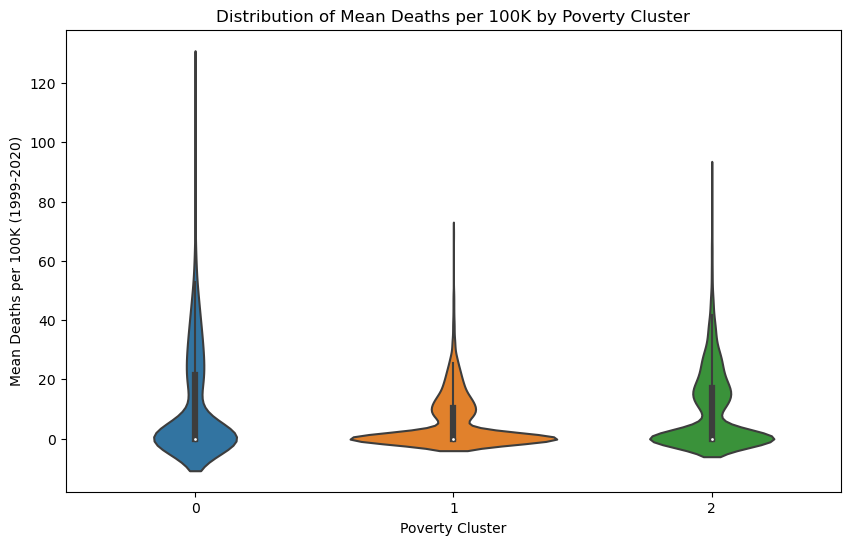

In [45]:
# add the cluster labels to a copy of the 'counties_gvd'

# Make a copy of 'counties_gvd'
counties_gvd_copy = counties_gvd.copy()

# Add the predicted clusters to the copied DataFrame
counties_gvd_copy = counties_gvd_copy.reset_index().merge(
    poverty_scaled_predictions[['kmeans_predictions']].reset_index(),
    how="left",
    on="county_Abbr"
).set_index('county_Abbr')


# rename 'kmeans_predictions' to 'poverty_cluster'
counties_gvd_copy.rename(columns={'kmeans_predictions': 'poverty_cluster'}, inplace=True)

# construct a violin plot relating poverty clustering and 

plt.figure(figsize=(10, 6))
sns.violinplot(x='poverty_cluster', y='deaths_per_100K_mean (1999-2020)', data=counties_gvd_copy)

plt.xlabel('Poverty Cluster')
plt.ylabel('Mean Deaths per 100K (1999-2020)')
plt.title('Distribution of Mean Deaths per 100K by Poverty Cluster')

plt.show()



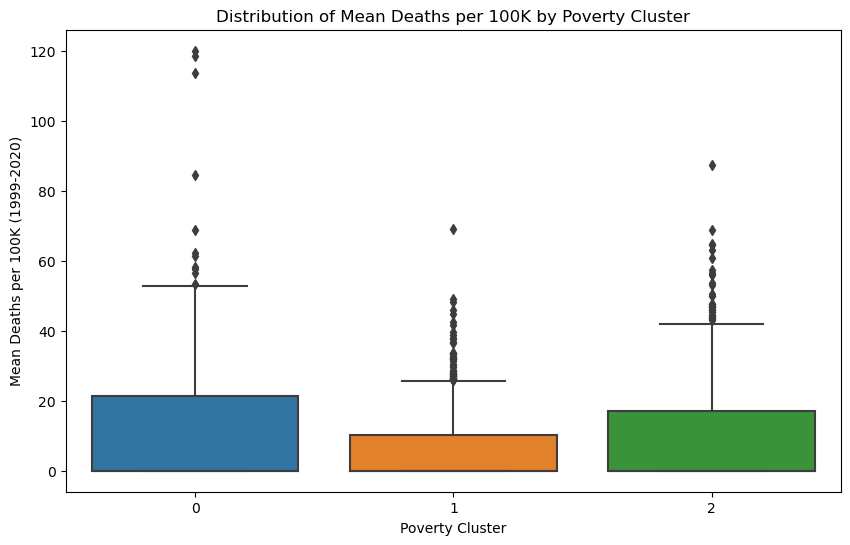

In [46]:
# construct a box plot relating crime clustering and deaths per 100K mean

plt.figure(figsize=(10, 6))
sns.boxplot(x='poverty_cluster', y='deaths_per_100K_mean (1999-2020)', data=counties_gvd_copy)

plt.xlabel('Poverty Cluster')
plt.ylabel('Mean Deaths per 100K (1999-2020)')
plt.title('Distribution of Mean Deaths per 100K by Poverty Cluster')

plt.show()

## Clustering based on Crime Data

In [47]:
# create a dataframe based on the poverty data
crime_df = counties_gvd[['county_Abbr', 'avg_murder (2002-2014)' , 'avg_rape (2002-2014)','avg_robbery (2002-2014)','avg_agasslt (2002-2014)','avg_burglry (2002-2014)','avg_larceny (2002-2014)','avg_mvtheft (2002-2014)','avg_arson (2002-2014)']]

# Setting 'county_Abbr' as index
crime_df = crime_df.set_index('county_Abbr')

# Use the `StandardScaler()` module from scikit-learn to normalize the data from the CSV file
crime_data_scaled = StandardScaler().fit_transform(crime_df[
    ['avg_murder (2002-2014)',
     'avg_rape (2002-2014)',
     'avg_robbery (2002-2014)',
     'avg_agasslt (2002-2014)',
     'avg_burglry (2002-2014)',
     'avg_larceny (2002-2014)',
     'avg_mvtheft (2002-2014)',
     'avg_arson (2002-2014)']
])

# Create a DataFrame with the scaled data
df_crime_data_scaled = pd.DataFrame(crime_data_scaled, columns=['avg_murder (2002-2014)',
     'avg_rape (2002-2014)',
     'avg_robbery (2002-2014)',
     'avg_agasslt (2002-2014)',
     'avg_burglry (2002-2014)',
     'avg_larceny (2002-2014)',
     'avg_mvtheft (2002-2014)',
     'avg_arson (2002-2014)'
])

# Copy the county_abbr names from the original data
df_crime_data_scaled["county_Abbr"] = crime_df.index

# Set the county_abbr column as index
df_crime_data_scaled = df_crime_data_scaled.set_index('county_Abbr')



# Display sample data
df_crime_data_scaled.head()



,avg_murder (2002-2014),avg_rape (2002-2014),avg_robbery (2002-2014),avg_agasslt (2002-2014),avg_burglry (2002-2014),avg_larceny (2002-2014),avg_mvtheft (2002-2014),avg_arson (2002-2014)
county_Abbr,,,,,,,,
"Autauga, AL - 1001",-0.139135,-0.111942,-0.118977,-0.153697,-0.142305,-0.123893,-0.120170,-0.067836
"Baldwin, AL - 1003",-0.024982,0.172695,-0.083106,-0.016340,0.063134,0.141642,-0.084631,-0.149135
"Barbour, AL - 1005",-0.166171,-0.260911,-0.149766,-0.202697,-0.249691,-0.245229,-0.166838,-0.217179
"Bibb, AL - 1007",-0.178187,-0.291059,-0.157286,-0.204482,-0.252304,-0.269217,-0.165968,-0.218946
"Blount, AL - 1009",-0.166171,-0.215688,-0.157387,-0.180554,-0.172919,-0.205907,-0.133177,-0.193319


### Find the Best Value for k Using the Original Data.

In [48]:
# Create a list with the number of k-values from 1 to 11
k = list(range(1, 11))

# Create an empty list to store the inertia values
inertia = []

# Create a for loop to compute the inertia with each possible value of k
# Inside the loop:
# 1. Create a KMeans model using the loop counter for the n_clusters
# 2. Fit the model to the data using `df_crime_data_scaled`
# 3. Append the model.inertia_ to the inertia list
for i in k:
    k_model = KMeans(n_clusters=i, random_state=0)
    k_model.fit(df_crime_data_scaled)
    inertia.append(k_model.inertia_)

    
# Create a dictionary with the data to plot the Elbow curve
elbow_data = {"k": k, "inertia": inertia}


# Create a DataFrame with the data to plot the Elbow curve
df_elbow = pd.DataFrame(elbow_data)

# differences between rows to get better assessment of best K value
df_elbow['inertia_diff'] = df_elbow['inertia'].diff()

# Plot a line chart with all the inertia values computed with 
# the different values of k to visually identify the optimal value for k.
elbow_orig = df_elbow.hvplot.line(
    x="k", 
    y="inertia", 
    title="Elbow Curve from original data", 
    xticks=k
)

elbow_orig



:Curve   [k]   (inertia)

## Cluster Crime Data with K-means Using the Original Data

In [49]:
# Initialize the K-Means model using the best value for k
model = KMeans(n_clusters=3, random_state=0)

# Fit the K-Means model using the scaled data
model.fit(df_crime_data_scaled)

# Predict the clusters to group the poverty data using the scaled data
kmeans_predictions = model.predict(df_crime_data_scaled)

# Create a copy of the DataFrame
crime_scaled_predictions = df_crime_data_scaled.copy()

# Add a new column to the DataFrame with the predicted clusters
crime_scaled_predictions['kmeans_predictions']=kmeans_predictions

# Create a scatter plot using hvPlot by setting 
# `x="avg_murder (2002-2014)"` and `y="avg_rape (2002-2014)"`. 
# Color the graph points with the labels found using K-Means and 
# add the county_Abbr name in the `hover_cols` parameter to identify 
# the cryptocurrency represented by each data point.

orig_cluster = crime_scaled_predictions.hvplot.scatter(
    x="avg_murder (2002-2014)",
    y="avg_rape (2002-2014)",
    by="kmeans_predictions",
    hover_cols=["county_Abbr"],
    title="Crime Data Clusters"
)

orig_cluster


:NdOverlay   [kmeans_predictions]
   :Scatter   [avg_murder (2002-2014)]   (avg_rape (2002-2014),county_Abbr)

In [50]:
# add the cluster labels to a copy of the 'counties_gvd'

# Make a copy of 'counties_gvd'
counties_gvd_copy = counties_gvd.copy()

# Add the predicted clusters to the copied DataFrame
counties_gvd_copy = counties_gvd_copy.reset_index().merge(
    crime_scaled_predictions[['kmeans_predictions']].reset_index(),
    how="left",
    on="county_Abbr"
).set_index('county_Abbr')


# rename 'kmeans_predictions' to 'crime_cluster'
counties_gvd_copy.rename(columns={'kmeans_predictions': 'crime_cluster'}, inplace=True)

# view the dataframe
counties_gvd_copy.head()



,index,county_code,state,Area name,county,Abbr,deaths_per_100K_mean (1999-2020),deaths_per_100K_std (1999-2020),deaths_per_100K_numb_years (1999-2020),growth_rate_gun_laws (1991-2017),avg_pop (2010-2019),avg_murder (2002-2014),avg_rape (2002-2014),avg_robbery (2002-2014),avg_agasslt (2002-2014),avg_burglry (2002-2014),avg_larceny (2002-2014),avg_mvtheft (2002-2014),avg_arson (2002-2014),Poverty % overall (2014),Poverty % ages 0-17 (2014),Poverty % related kids age 5-17 (2014),"Percent of adults with less than a high school diploma, 2010-2014","Percent of adults with a high school diploma only, 2010-2014","Percent of adults completing some college or associate's degree, 2010-2014","Percent of adults with a bachelor's degree or higher, 2010-2014",avg_unemp_rate_2010_2015,% white pop avg (2010-2019),% black pop avg (2010-2019),% asian pop avg (2010-2019),% indian pop avg (2010-2019),% pacific pop avg (2010-2019),% two pop avg (2010-2019),% not hisp pop avg (2010-2019),% hisp pop avg (2010-2019),chain restaurants per 100K,places of worship per 100K,name,lng,lat,crime_cluster
county_Abbr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Autauga, AL - 1001",0,1001,Alabama,Autauga County,Autauga,AL,21.971571,3.796015,7.0,-1.282051,55127.10,1.307692,18.307692,33.769231,87.538462,332.230769,1161.538462,99.153846,13.461538,13.1,18.1,17.4,13.832694,33.502608,30.723374,21.941324,6.916667,77.889459,18.766813,1.073882,0.482159,0.092695,1.694992,97.354659,2.645341,105.211,110.653,Autauga,-86.642900,32.535142,0
"Baldwin, AL - 1003",1,1003,Alabama,Baldwin County,Baldwin,AL,13.911000,3.044843,22.0,-1.282051,123611.65,4.230769,43.000000,60.923077,235.461538,797.846154,2943.769231,158.846154,6.384615,13.0,19.8,18.7,10.966706,28.815086,31.593718,28.624491,7.466667,81.380598,15.259808,1.070894,0.675584,0.064112,1.549004,95.942130,4.057870,511.279,122.966,Baldwin,-87.722745,30.727825,0
"Barbour, AL - 1005",2,1005,Alabama,Barbour County,Barbour,AL,0.000000,0.000000,0.0,-1.282051,21472.95,0.615385,5.384615,10.461538,34.769231,88.846154,347.153846,20.769231,0.461538,25.4,38.1,37.0,25.430028,33.446592,27.516458,13.606923,10.850000,68.102892,29.607716,0.374425,0.588415,0.114097,1.212456,96.934282,3.065718,228.194,121.083,Barbour,-85.391068,31.870090,0
"Bibb, AL - 1007",3,1007,Alabama,Bibb County,Bibb,AL,0.000000,0.000000,0.0,-1.282051,88479.35,0.307692,2.769231,4.769231,32.846154,82.923077,186.153846,22.230769,0.307692,18.1,26.8,25.2,22.100363,40.062488,27.596761,10.240388,8.700000,46.393198,50.112653,1.744023,0.293741,0.116468,1.339917,96.980934,3.019066,19.214,50.859,Bibb,-87.126814,32.998376,0
"Blount, AL - 1009",4,1009,Alabama,Blount County,Blount,AL,20.789818,3.371535,11.0,-1.282051,92353.30,0.615385,9.307692,4.692308,58.615385,262.846154,611.076923,77.307692,2.538462,17.5,24.1,22.5,21.937417,34.495032,31.304415,12.263136,7.216667,94.773982,2.525627,0.679618,0.478110,0.074876,1.467787,95.074459,4.925541,60.637,102.866,Blount,-86.567006,33.980871,0


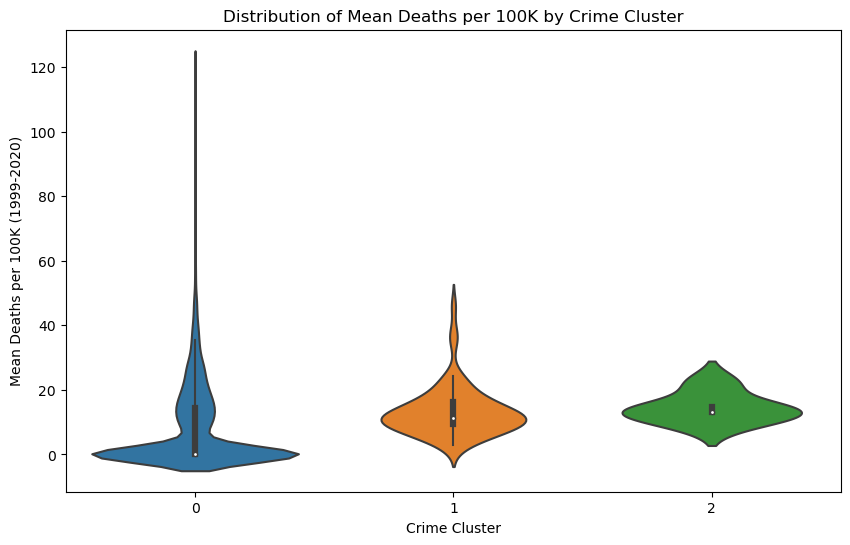

In [51]:
# construct a violin plot relating crime clustering and deaths per 100K mean

plt.figure(figsize=(10, 6))
sns.violinplot(x='crime_cluster', y='deaths_per_100K_mean (1999-2020)', data=counties_gvd_copy)

plt.xlabel('Crime Cluster')
plt.ylabel('Mean Deaths per 100K (1999-2020)')
plt.title('Distribution of Mean Deaths per 100K by Crime Cluster')

plt.show()


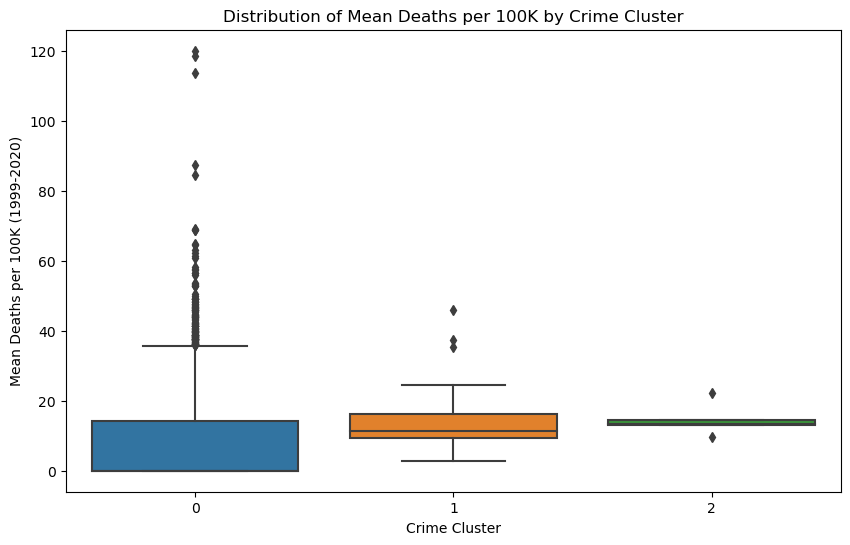

In [52]:
# construct a box plot relating crime clustering and deaths per 100K mean

plt.figure(figsize=(10, 6))
sns.boxplot(x='crime_cluster', y='deaths_per_100K_mean (1999-2020)', data=counties_gvd_copy)

plt.xlabel('Crime Cluster')
plt.ylabel('Mean Deaths per 100K (1999-2020)')
plt.title('Distribution of Mean Deaths per 100K by Crime Cluster')

plt.show()


## Clustering based on Race Data

In [53]:
# create a dataframe based on the poverty data
race_df = counties_gvd[['county_Abbr', '% white pop avg (2010-2019)','% black pop avg (2010-2019)','% asian pop avg (2010-2019)','% indian pop avg (2010-2019)','% pacific pop avg (2010-2019)','% two pop avg (2010-2019)']]

# Setting 'county_Abbr' as index
race_df = race_df.set_index('county_Abbr')

# Use the `StandardScaler()` module from scikit-learn to normalize the data from the CSV file
race_data_scaled = StandardScaler().fit_transform(race_df[
    ['% white pop avg (2010-2019)',
     '% black pop avg (2010-2019)',
     '% asian pop avg (2010-2019)',
     '% indian pop avg (2010-2019)',
     '% pacific pop avg (2010-2019)',
     '% two pop avg (2010-2019)']
])

# Create a DataFrame with the scaled data
df_race_data_scaled = pd.DataFrame(race_data_scaled, columns=['% white pop avg (2010-2019)',
                                                              '% black pop avg (2010-2019)',
                                                              '% asian pop avg (2010-2019)',
                                                              '% indian pop avg (2010-2019)',
                                                              '% pacific pop avg (2010-2019)',
                                                              '% two pop avg (2010-2019)'
])

# Copy the county_abbr names from the original data
df_race_data_scaled["county_Abbr"] = race_df.index

# Set the county_abbr column as index
df_race_data_scaled = df_race_data_scaled.set_index('county_Abbr')



# Display sample data
df_race_data_scaled.head()



,% white pop avg (2010-2019),% black pop avg (2010-2019),% asian pop avg (2010-2019),% indian pop avg (2010-2019),% pacific pop avg (2010-2019),% two pop avg (2010-2019)
county_Abbr,,,,,,
"Autauga, AL - 1001",-0.430380,0.686961,-0.290763,-0.252584,-0.130732,-0.304680
"Baldwin, AL - 1003",-0.174637,0.404389,-0.291909,-0.221090,-0.302157,-0.443637
"Barbour, AL - 1005",-1.147294,1.560450,-0.559218,-0.235283,-0.002373,-0.763976
"Bibb, AL - 1007",-2.737635,3.212605,-0.033560,-0.283262,0.011846,-0.642654
"Blount, AL - 1009",0.806493,-0.621649,-0.442083,-0.253243,-0.237603,-0.520942


### Find the Best Value for k Using the Original Data.

In [54]:
# Create a list with the number of k-values from 1 to 11
k = list(range(1, 11))

# Create an empty list to store the inertia values
inertia = []

# Create a for loop to compute the inertia with each possible value of k
# Inside the loop:
# 1. Create a KMeans model using the loop counter for the n_clusters
# 2. Fit the model to the data using `df_race_data_scaled`
# 3. Append the model.inertia_ to the inertia list
for i in k:
    k_model = KMeans(n_clusters=i, random_state=0)
    k_model.fit(df_race_data_scaled)
    inertia.append(k_model.inertia_)

    
# Create a dictionary with the data to plot the Elbow curve
elbow_data = {"k": k, "inertia": inertia}


# Create a DataFrame with the data to plot the Elbow curve
df_elbow = pd.DataFrame(elbow_data)

# differences between rows to get better assessment of best K value
df_elbow['inertia_diff'] = df_elbow['inertia'].diff()

# Plot a line chart with all the inertia values computed with 
# the different values of k to visually identify the optimal value for k.
elbow_orig = df_elbow.hvplot.line(
    x="k", 
    y="inertia", 
    title="Elbow Curve from original data", 
    xticks=k
)

elbow_orig



:Curve   [k]   (inertia)

### Cluster Poverty Data with K-means Using the Original Data

In [55]:
# Initialize the K-Means model using the best value for k
model = KMeans(n_clusters=3, random_state=0)

# Fit the K-Means model using the scaled data
model.fit(df_race_data_scaled)

# Predict the clusters to group the poverty data using the scaled data
kmeans_predictions = model.predict(df_race_data_scaled)

# Create a copy of the DataFrame
race_scaled_predictions = df_race_data_scaled.copy()

# Add a new column to the DataFrame with the predicted clusters
race_scaled_predictions['kmeans_predictions']=kmeans_predictions

# Create a scatter plot using hvPlot by setting 
# `x="% white pop avg (2010-2019)"` and `y="% black pop avg (2010-2019)"`. 
# Color the graph points with the labels found using K-Means and 
# add the county_Abbr name in the `hover_cols` parameter to identify 
# the cryptocurrency represented by each data point.

orig_cluster = race_scaled_predictions.hvplot.scatter(
    x="% white pop avg (2010-2019)",
    y="% black pop avg (2010-2019)",
    by="kmeans_predictions",
    hover_cols=["county_Abbr"],
    title="Race Data Clusters"
)

orig_cluster


:NdOverlay   [kmeans_predictions]
   :Scatter   [% white pop avg (2010-2019)]   (% black pop avg (2010-2019),county_Abbr)

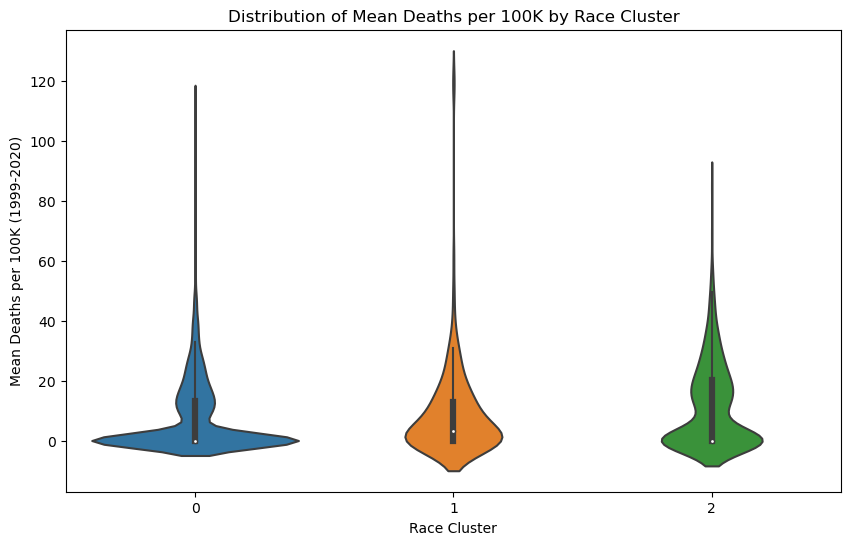

In [56]:
# add the cluster labels to a copy of the 'counties_gvd'

# Make a copy of 'counties_gvd'
counties_gvd_copy = counties_gvd.copy()

# Add the predicted clusters to the copied DataFrame
counties_gvd_copy = counties_gvd_copy.reset_index().merge(
    race_scaled_predictions[['kmeans_predictions']].reset_index(),
    how="left",
    on="county_Abbr"
).set_index('county_Abbr')


# rename 'kmeans_predictions' to 'poverty_cluster'
counties_gvd_copy.rename(columns={'kmeans_predictions': 'race_cluster'}, inplace=True)

# construct a violin plot relating poverty clustering and 

plt.figure(figsize=(10, 6))
sns.violinplot(x='race_cluster', y='deaths_per_100K_mean (1999-2020)', data=counties_gvd_copy)

plt.xlabel('Race Cluster')
plt.ylabel('Mean Deaths per 100K (1999-2020)')
plt.title('Distribution of Mean Deaths per 100K by Race Cluster')

plt.show()

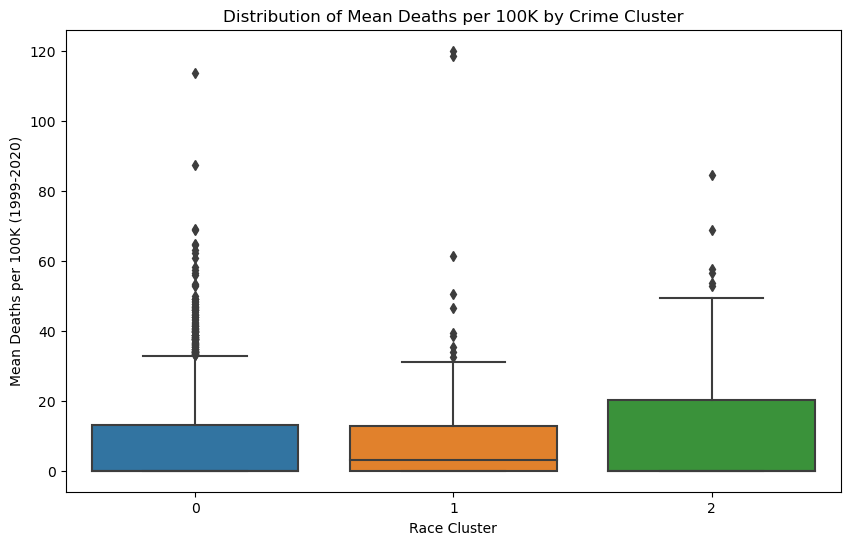

In [57]:
# construct a box plot relating crime clustering and deaths per 100K mean

plt.figure(figsize=(10, 6))
sns.boxplot(x='race_cluster', y='deaths_per_100K_mean (1999-2020)', data=counties_gvd_copy)

plt.xlabel('Race Cluster')
plt.ylabel('Mean Deaths per 100K (1999-2020)')
plt.title('Distribution of Mean Deaths per 100K by Crime Cluster')

plt.show()

## Clustering based on Education Data

In [58]:
# create a dataframe based on the poverty data
educ_df = counties_gvd[['county_Abbr', 'Percent of adults with less than a high school diploma, 2010-2014','Percent of adults with a high school diploma only, 2010-2014' ,"Percent of adults completing some college or associate's degree, 2010-2014" ,"Percent of adults with a bachelor's degree or higher, 2010-2014"]]

# Setting 'county_Abbr' as index
educ_df = educ_df.set_index('county_Abbr')

# Use the `StandardScaler()` module from scikit-learn to normalize the data from the CSV file
educ_data_scaled = StandardScaler().fit_transform(educ_df[
    ['Percent of adults with less than a high school diploma, 2010-2014',
     'Percent of adults with a high school diploma only, 2010-2014',
     "Percent of adults completing some college or associate's degree, 2010-2014",
     "Percent of adults with a bachelor's degree or higher, 2010-2014"]
])

# Create a DataFrame with the scaled data
df_educ_data_scaled = pd.DataFrame(educ_data_scaled, columns=[
    'Percent of adults with less than a high school diploma, 2010-2014',
    'Percent of adults with a high school diploma only, 2010-2014',
    "Percent of adults completing some college or associate's degree, 2010-2014",
    "Percent of adults with a bachelor's degree or higher, 2010-2014"
])

# Copy the county_abbr names from the original data
df_educ_data_scaled["county_Abbr"] = educ_df.index

# Set the county_abbr column as index
df_educ_data_scaled = df_educ_data_scaled.set_index('county_Abbr')



# Display sample data
df_educ_data_scaled.head()



,"Percent of adults with less than a high school diploma, 2010-2014","Percent of adults with a high school diploma only, 2010-2014","Percent of adults completing some college or associate's degree, 2010-2014","Percent of adults with a bachelor's degree or higher, 2010-2014"
county_Abbr,,,,
"Autauga, AL - 1001",-0.177805,-0.183844,0.123301,0.207598
"Baldwin, AL - 1003",-0.602443,-0.851879,0.290349,0.958507
"Barbour, AL - 1005",1.540508,-0.191827,-0.492214,-0.728841
"Bibb, AL - 1007",1.047170,0.751028,-0.476801,-1.107099
"Blount, AL - 1009",1.023027,-0.042410,0.234822,-0.879826


### Find the Best Value for k Using the Original Data.

In [59]:
# Create a list with the number of k-values from 1 to 11
k = list(range(1, 11))

# Create an empty list to store the inertia values
inertia = []

# Create a for loop to compute the inertia with each possible value of k
# Inside the loop:
# 1. Create a KMeans model using the loop counter for the n_clusters
# 2. Fit the model to the data using `df_educ_data_scaled`
# 3. Append the model.inertia_ to the inertia list
for i in k:
    k_model = KMeans(n_clusters=i, random_state=0)
    k_model.fit(df_educ_data_scaled)
    inertia.append(k_model.inertia_)

    
# Create a dictionary with the data to plot the Elbow curve
elbow_data = {"k": k, "inertia": inertia}


# Create a DataFrame with the data to plot the Elbow curve
df_elbow = pd.DataFrame(elbow_data)

# differences between rows to get better assessment of best K value
df_elbow['inertia_diff'] = df_elbow['inertia'].diff()

# Plot a line chart with all the inertia values computed with 
# the different values of k to visually identify the optimal value for k.
elbow_orig = df_elbow.hvplot.line(
    x="k", 
    y="inertia", 
    title="Elbow Curve from original data", 
    xticks=k
)

elbow_orig



:Curve   [k]   (inertia)

## Cluster Education Data with K-means Using the Original Data

In [60]:
# Initialize the K-Means model using the best value for k
model = KMeans(n_clusters=3, random_state=0)

# Fit the K-Means model using the scaled data
model.fit(df_educ_data_scaled)

# Predict the clusters to group the poverty data using the scaled data
kmeans_predictions = model.predict(df_educ_data_scaled)

# Create a copy of the DataFrame
educ_scaled_predictions = df_educ_data_scaled.copy()

# Add a new column to the DataFrame with the predicted clusters
educ_scaled_predictions['kmeans_predictions']=kmeans_predictions

# Create a scatter plot using hvPlot by setting 
# `x='Percent of adults with less than a high school diploma, 2010-2014"` and `y="Percent of adults with a high school diploma only, 2010-2014"`. 
# Color the graph points with the labels found using K-Means and 
# add the county_Abbr name in the `hover_cols` parameter to identify 
# the cryptocurrency represented by each data point.

orig_cluster = educ_scaled_predictions.hvplot.scatter(
    x="Percent of adults with less than a high school diploma, 2010-2014",
    y="Percent of adults with a high school diploma only, 2010-2014",
    by="kmeans_predictions",
    hover_cols=["county_Abbr"],
    title="Crime Data Clusters"
)

orig_cluster




:NdOverlay   [kmeans_predictions]
   :Scatter   [Percent of adults with less than a high school diploma, 2010-2014]   (Percent of adults with a high school diploma only, 2010-2014,county_Abbr)

In [61]:
# add the cluster labels to a copy of the 'counties_gvd'

# Make a copy of 'counties_gvd'
counties_gvd_copy = counties_gvd.copy()

# Add the predicted clusters to the copied DataFrame
counties_gvd_copy = counties_gvd_copy.reset_index().merge(
    educ_scaled_predictions[['kmeans_predictions']].reset_index(),
    how="left",
    on="county_Abbr"
).set_index('county_Abbr')


# rename 'kmeans_predictions' to 'educ_cluster'
counties_gvd_copy.rename(columns={'kmeans_predictions': 'educ_cluster'}, inplace=True)

# view the dataframe
counties_gvd_copy.head()



,index,county_code,state,Area name,county,Abbr,deaths_per_100K_mean (1999-2020),deaths_per_100K_std (1999-2020),deaths_per_100K_numb_years (1999-2020),growth_rate_gun_laws (1991-2017),avg_pop (2010-2019),avg_murder (2002-2014),avg_rape (2002-2014),avg_robbery (2002-2014),avg_agasslt (2002-2014),avg_burglry (2002-2014),avg_larceny (2002-2014),avg_mvtheft (2002-2014),avg_arson (2002-2014),Poverty % overall (2014),Poverty % ages 0-17 (2014),Poverty % related kids age 5-17 (2014),"Percent of adults with less than a high school diploma, 2010-2014","Percent of adults with a high school diploma only, 2010-2014","Percent of adults completing some college or associate's degree, 2010-2014","Percent of adults with a bachelor's degree or higher, 2010-2014",avg_unemp_rate_2010_2015,% white pop avg (2010-2019),% black pop avg (2010-2019),% asian pop avg (2010-2019),% indian pop avg (2010-2019),% pacific pop avg (2010-2019),% two pop avg (2010-2019),% not hisp pop avg (2010-2019),% hisp pop avg (2010-2019),chain restaurants per 100K,places of worship per 100K,name,lng,lat,educ_cluster
county_Abbr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Autauga, AL - 1001",0,1001,Alabama,Autauga County,Autauga,AL,21.971571,3.796015,7.0,-1.282051,55127.10,1.307692,18.307692,33.769231,87.538462,332.230769,1161.538462,99.153846,13.461538,13.1,18.1,17.4,13.832694,33.502608,30.723374,21.941324,6.916667,77.889459,18.766813,1.073882,0.482159,0.092695,1.694992,97.354659,2.645341,105.211,110.653,Autauga,-86.642900,32.535142,0
"Baldwin, AL - 1003",1,1003,Alabama,Baldwin County,Baldwin,AL,13.911000,3.044843,22.0,-1.282051,123611.65,4.230769,43.000000,60.923077,235.461538,797.846154,2943.769231,158.846154,6.384615,13.0,19.8,18.7,10.966706,28.815086,31.593718,28.624491,7.466667,81.380598,15.259808,1.070894,0.675584,0.064112,1.549004,95.942130,4.057870,511.279,122.966,Baldwin,-87.722745,30.727825,2
"Barbour, AL - 1005",2,1005,Alabama,Barbour County,Barbour,AL,0.000000,0.000000,0.0,-1.282051,21472.95,0.615385,5.384615,10.461538,34.769231,88.846154,347.153846,20.769231,0.461538,25.4,38.1,37.0,25.430028,33.446592,27.516458,13.606923,10.850000,68.102892,29.607716,0.374425,0.588415,0.114097,1.212456,96.934282,3.065718,228.194,121.083,Barbour,-85.391068,31.870090,1
"Bibb, AL - 1007",3,1007,Alabama,Bibb County,Bibb,AL,0.000000,0.000000,0.0,-1.282051,88479.35,0.307692,2.769231,4.769231,32.846154,82.923077,186.153846,22.230769,0.307692,18.1,26.8,25.2,22.100363,40.062488,27.596761,10.240388,8.700000,46.393198,50.112653,1.744023,0.293741,0.116468,1.339917,96.980934,3.019066,19.214,50.859,Bibb,-87.126814,32.998376,1
"Blount, AL - 1009",4,1009,Alabama,Blount County,Blount,AL,20.789818,3.371535,11.0,-1.282051,92353.30,0.615385,9.307692,4.692308,58.615385,262.846154,611.076923,77.307692,2.538462,17.5,24.1,22.5,21.937417,34.495032,31.304415,12.263136,7.216667,94.773982,2.525627,0.679618,0.478110,0.074876,1.467787,95.074459,4.925541,60.637,102.866,Blount,-86.567006,33.980871,1


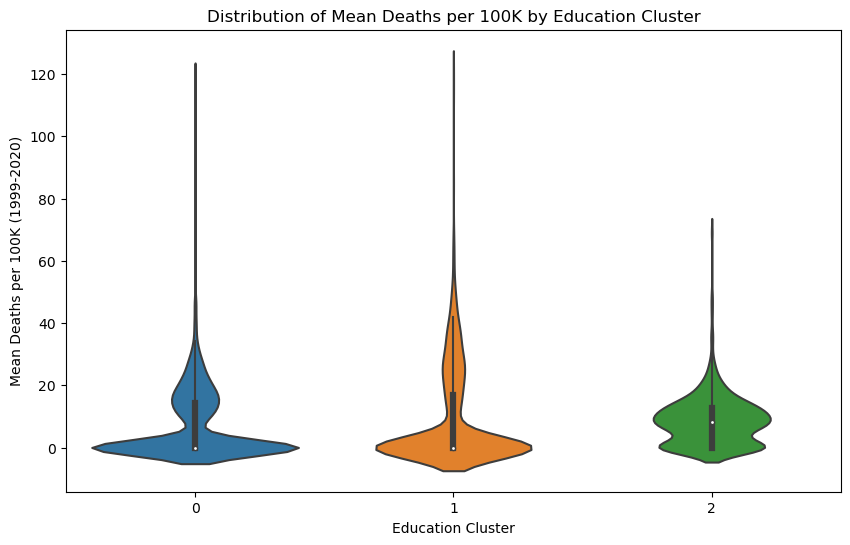

In [62]:
# construct a violin plot relating crime clustering and deaths per 100K mean

plt.figure(figsize=(10, 6))
sns.violinplot(x='educ_cluster', y='deaths_per_100K_mean (1999-2020)', data=counties_gvd_copy)

plt.xlabel('Education Cluster')
plt.ylabel('Mean Deaths per 100K (1999-2020)')
plt.title('Distribution of Mean Deaths per 100K by Education Cluster')

plt.show()


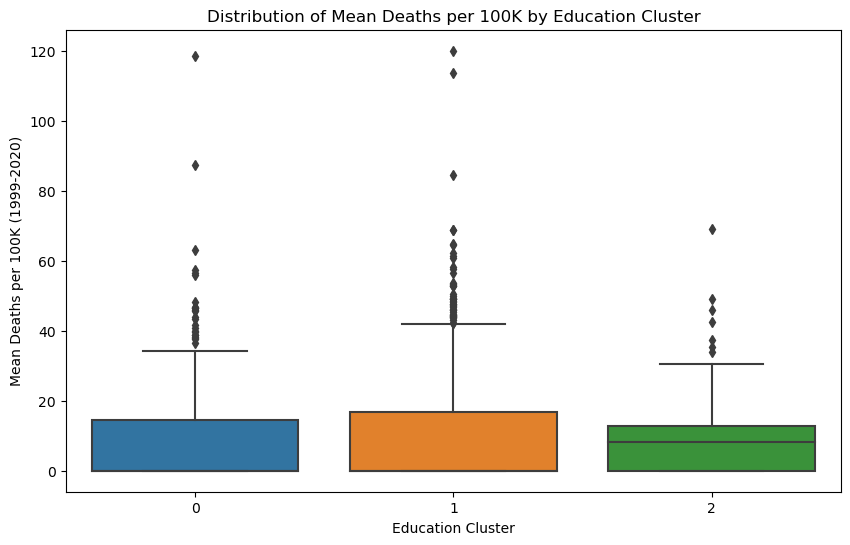

In [63]:
# construct a box plot relating education clustering and deaths per 100K mean

plt.figure(figsize=(10, 6))
sns.boxplot(x='educ_cluster', y='deaths_per_100K_mean (1999-2020)', data=counties_gvd_copy)

plt.xlabel('Education Cluster')
plt.ylabel('Mean Deaths per 100K (1999-2020)')
plt.title('Distribution of Mean Deaths per 100K by Education Cluster')

plt.show()

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

## END OF CODING